In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

path = "/content/gdrive/My Drive/Datasets/MNIST/"

# Library Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from time import time

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random as r

torch.manual_seed(0)
torch.cuda.manual_seed(0)

def breaker():
    print("\n" + 50*"-" + "\n")

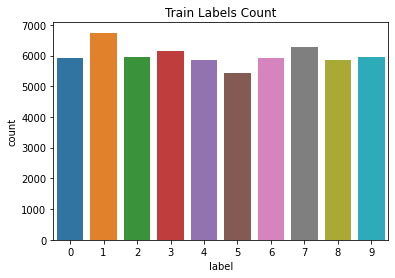

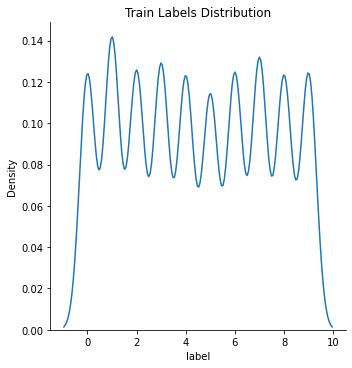

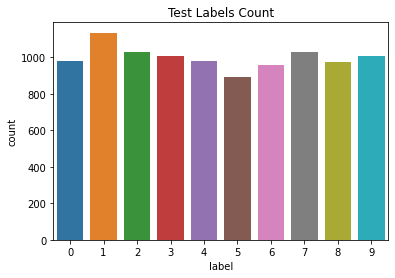

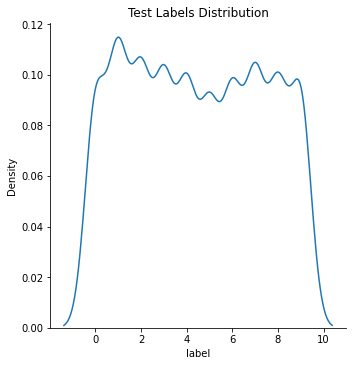

In [3]:
tr_set = pd.read_csv(path + "train.csv")
ts_set = pd.read_csv(path + "test.csv")

plt.figure()
sns.countplot(data=tr_set, x="label")
plt.title("Train Labels Count")
plt.show()
sns.displot(tr_set["label"], kind="kde")
plt.title("Train Labels Distribution")
plt.show()

plt.figure()
sns.countplot(data=ts_set, x="label")
plt.title("Test Labels Count")
plt.show()
sns.displot(ts_set["label"], kind="kde")
plt.title("Test Labels Distribution")
plt.show()

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(tr_set.iloc[:, 1:].copy().values,
                                                      tr_set.iloc[:, 0].copy().values,
                                                      shuffle=True,
                                                      random_state=0,
                                                      stratify=tr_set.iloc[:, 0].copy().values) 

X_test, y_test = ts_set.iloc[:, 1:].copy().values, ts_set.iloc[:, 0].copy().values

MAX_VALUE = 255

X_train = np.divide(X_train, MAX_VALUE)
X_valid = np.divide(X_valid, MAX_VALUE)
X_test  = np.divide(X_test, MAX_VALUE)

del tr_set, ts_set

print("Garbage Collected : {}".format(gc.collect()))

Garbage Collected : 11040


# Setup

In [5]:
class Dataset(Dataset):
    def __init__(this, X=None, y=None):
        this.X = X.reshape(X.shape[0], 1, 28, 28)
        this.y = y

    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        return torch.FloatTensor(this.X[idx]), torch.LongTensor(this.y[idx])

In [6]:
class CFG():
    tr_batch_size = 128
    va_batch_size = 128
    ts_batch_size = 128

    ae_epochs = 25
    cl_epochs = 25

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __init__(this, code_size):
        this.code_size = code_size

cfg = CFG(code_size=2048)

tr_data_setup = Dataset(X_train, y_train.reshape(-1, 1))
va_data_setup = Dataset(X_valid, y_valid.reshape(-1, 1))
ts_data_setup = Dataset(X_test, y_test.reshape(-1, 1))

DLS = {
       "train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True),
       "valid" : DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=False),
       "test"  : DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)
      }

In [7]:
def fit_(model=None, optimizer=None, scheduler=None, epochs=None, 
             trainloader=None, validloader=None, 
             criterion=None, device=None, 
             classify=False, verbose=False):
    
    breaker()
    print("Training ...")
    breaker()

    model.to(device)
    LPT = []
    LPV = []
    start_time = time()
    for e in range(epochs):
        trainLossPerPass = 0
        validLossPerPass = 0

        model.train()
        for X, y in trainloader:
            X = X.to(device)
            if classify:
                y = y.to(device).view(-1)
            else:
                y = y.to(device)

            optimizer.zero_grad()
            output = model(X)

            if classify:
                loss = criterion(output, y)
            else:
                loss = criterion(output, X)
            
            loss.backward()
            trainLossPerPass += (loss.item() / y.shape[0])
            optimizer.step()
        LPT.append(trainLossPerPass)

        model.eval()
        for X, y in validloader:
            X = X.to(device)
            if classify:
                y = y.to(device).view(-1)
            else:
                y = y.to(device)
            
            with torch.no_grad():
                output = model(X)
                if classify:
                    loss = criterion(output, y)
                else:
                    loss = criterion(output, X)
                validLossPerPass += (loss.item() / y.shape[0])
        LPV.append(validLossPerPass)

        if scheduler:
            scheduler.step()
        
        if verbose:
            print("Epoch : {} | Training Loss : {:.5f} | Validation Loss : {:.5f}".format(e+1, trainLossPerPass, validLossPerPass))    

    breaker()
    print("Time Taken [{} Epochs] : {:.2f} minutes".format(epochs, (time()-start_time)/60))
    breaker()
    print("Training Complete")
    breaker()

    return LPT, LPV


def predict_(model=None, dataloader=None, batch_size=None, device=None, path=None):
    y_pred = torch.zeros(batch_size, 1).to(device)

    model.eval()

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            Prob = torch.exp(model(X))
        Pred = torch.argmax(Prob, dim=1)
        y_pred = torch.cat((y_pred, Pred.view(-1, 1)), dim=0)
    return y_pred[batch_size:].detach().cpu().numpy().reshape(-1).astype(int)

# Autoencoder

In [8]:
class CAE(nn.Module):
    def __init__(this, code_size=None):
        super().__init__()

        this.encoder = nn.Sequential()
        this.encoder.add_module("Convolution 1", nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 1", nn.BatchNorm2d(num_features=64))
        this.encoder.add_module("MaxPool 1", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 1", nn.ReLU())
        this.encoder.add_module("Convolution 2", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 2", nn.BatchNorm2d(num_features=128))
        this.encoder.add_module("MaxPool 2", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 2", nn.ReLU())
        this.encoder.add_module("Convolution 3", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 3", nn.BatchNorm2d(num_features=256))
        this.encoder.add_module("MaxPool 3", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 3", nn.ReLU())

        this.latentlayer = nn.Sequential()
        this.latentlayer.add_module("Latent Layer", nn.Linear(in_features=256*3*3, out_features=code_size))
        this.latentlayer.add_module("Latent Activation", nn.ReLU())

        this.reverselatentlayer = nn.Sequential()
        this.reverselatentlayer.add_module("Latent Layer", nn.Linear(in_features=code_size, out_features=256*3*3))
        this.reverselatentlayer.add_module("Latent Activation", nn.ReLU())

        this.decoder = nn.Sequential()
        this.decoder.add_module("Deconvolution 1", nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2))
        this.decoder.add_module("Activation 1", nn.ReLU())
        this.decoder.add_module("Deconvolution 2", nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2))
        this.decoder.add_module("Activation 2", nn.ReLU())
        this.decoder.add_module("Deactivation 3", nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=2, stride=2))
        this.decoder.add_module("Activation 3", nn.Sigmoid())

    def getOptimizer(this, lr=1e-3, wd=0):
        return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)

    def forward(this, x):
        x = this.encoder(x)
        x = x.view(x.shape[0], -1)
        x = this.latentlayer(x)
        x = this.reverselatentlayer(x)
        x = x.view(x.shape[0], 256, 3, 3)
        x = this.decoder(x)
        return x


--------------------------------------------------

Training ...

--------------------------------------------------

Epoch : 1 | Training Loss : 0.08700 | Validation Loss : 0.01153
Epoch : 2 | Training Loss : 0.02537 | Validation Loss : 0.00693
Epoch : 3 | Training Loss : 0.01818 | Validation Loss : 0.00541
Epoch : 4 | Training Loss : 0.01499 | Validation Loss : 0.00481
Epoch : 5 | Training Loss : 0.01293 | Validation Loss : 0.00452
Epoch : 6 | Training Loss : 0.01174 | Validation Loss : 0.00399
Epoch : 7 | Training Loss : 0.01043 | Validation Loss : 0.00360
Epoch : 8 | Training Loss : 0.00992 | Validation Loss : 0.00387
Epoch : 9 | Training Loss : 0.00937 | Validation Loss : 0.00324
Epoch : 10 | Training Loss : 0.00875 | Validation Loss : 0.00315
Epoch : 11 | Training Loss : 0.00852 | Validation Loss : 0.00293
Epoch : 12 | Training Loss : 0.00784 | Validation Loss : 0.00329
Epoch : 13 | Training Loss : 0.00778 | Validation Loss : 0.00273
Epoch : 14 | Training Loss : 0.00728 | Valida

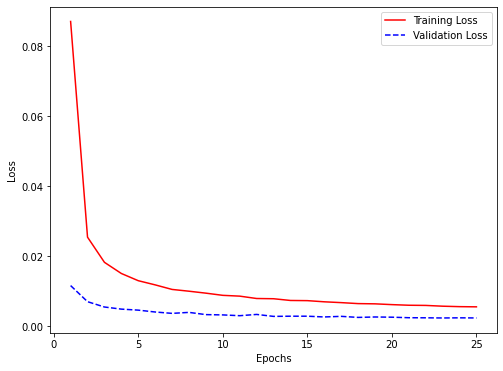

In [9]:
cae_model = CAE(code_size=cfg.code_size)
cae_optimizer = cae_model.getOptimizer(lr=1e-3, wd=0)

LPT, LPV = fit_(model=cae_model, optimizer=cae_optimizer, epochs=cfg.ae_epochs,
                trainloader=DLS["train"], validloader=DLS["valid"],
                criterion=nn.MSELoss(), device=cfg.device,
                verbose=True)

plt.figure(figsize=(8, 6))
plt.plot([i+1 for i in range(len(LPT))], LPT, "r", label="Training Loss")
plt.plot([i+1 for i in range(len(LPV))], LPV, "b--", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

**Evaluation**

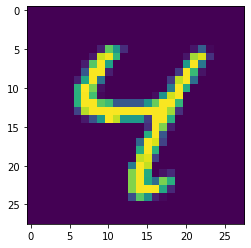

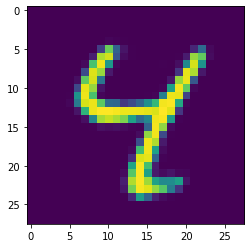

In [10]:
ts_x, ts_y = next(iter(DLS["test"]))

sample_no = r.randint(0, cfg.ts_batch_size)
plt.figure()
plt.imshow(ts_x[sample_no, 0, :, :].detach().cpu().numpy())
plt.show()

cae_model.eval()
recon_image = cae_model(ts_x.to(cfg.device))

plt.figure()
output = recon_image.reshape(recon_image.shape[0], 1, 28, 28)
plt.imshow(recon_image[sample_no, 0, :, :].detach().cpu().numpy())
plt.show()

for names, params in cae_model.named_parameters():
    params.requires_grad = False

# Classification

In [11]:
class CNN(nn.Module):
    def __init__(this, code_size=None):
        super().__init__()

        this.encoder = nn.Sequential()
        this.encoder.add_module("Convolution 1", nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 1", nn.BatchNorm2d(num_features=64))
        this.encoder.add_module("MaxPool 1", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 1", nn.ReLU())
        this.encoder.add_module("Convolution 2", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 2", nn.BatchNorm2d(num_features=128))
        this.encoder.add_module("MaxPool 2", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 2", nn.ReLU())
        this.encoder.add_module("Convolution 3", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1))
        this.encoder.add_module("BatchNorm 3", nn.BatchNorm2d(num_features=256))
        this.encoder.add_module("MaxPool 3", nn.MaxPool2d(kernel_size=2))
        this.encoder.add_module("Activation 3", nn.ReLU())

        this.latentlayer = nn.Sequential()
        this.latentlayer.add_module("Latent Layer", nn.Linear(in_features=256*3*3, out_features=code_size))
        this.latentlayer.add_module("Latent Activation", nn.ReLU())

        this.FC = nn.Linear(in_features=code_size, out_features=10)

    def getOptimizer(this, lr=1e-3, wd=0):
        return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)

    def forward(this, x):
        x = this.encoder(x)
        x = x.view(x.shape[0], -1)
        x = this.latentlayer(x)
        x = F.log_softmax(this.FC(x), dim=1)
        return x

In [12]:
cnn_model = CNN(code_size=cfg.code_size)

for names, params in cnn_model.named_parameters():
    params = cae_model.state_dict()[names]
    if names == "latentlayer.Latent Layer.bias":
        break
    
for names, params in cnn_model.named_parameters():
    params.requires_grad = False
    if names == "latentlayer.Latent Layer.bias":
        break


--------------------------------------------------

Training ...

--------------------------------------------------

Epoch : 1 | Training Loss : 1.10133 | Validation Loss : 0.15614
Epoch : 2 | Training Loss : 0.38480 | Validation Loss : 0.11048
Epoch : 3 | Training Loss : 0.28430 | Validation Loss : 0.09377
Epoch : 4 | Training Loss : 0.23243 | Validation Loss : 0.08084
Epoch : 5 | Training Loss : 0.19808 | Validation Loss : 0.07411
Epoch : 6 | Training Loss : 0.17303 | Validation Loss : 0.07010
Epoch : 7 | Training Loss : 0.15309 | Validation Loss : 0.06625
Epoch : 8 | Training Loss : 0.13964 | Validation Loss : 0.06257
Epoch : 9 | Training Loss : 0.12576 | Validation Loss : 0.06227
Epoch : 10 | Training Loss : 0.11673 | Validation Loss : 0.06017
Epoch : 11 | Training Loss : 0.10495 | Validation Loss : 0.05838
Epoch : 12 | Training Loss : 0.09767 | Validation Loss : 0.05835
Epoch : 13 | Training Loss : 0.08779 | Validation Loss : 0.05461
Epoch : 14 | Training Loss : 0.08314 | Valida

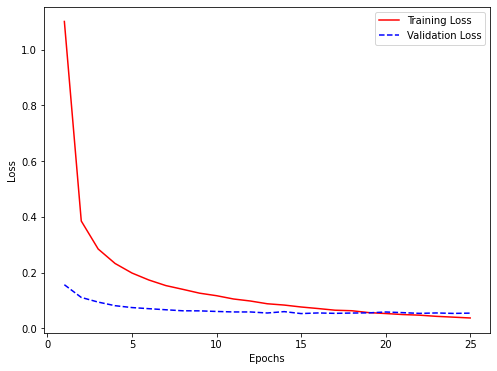

In [13]:
cnn_optimizer = cnn_model.getOptimizer(lr=1e-3, wd=0)

LPT, LPV = fit_(model=cnn_model, optimizer=cnn_optimizer, epochs=cfg.cl_epochs,
                trainloader=DLS["train"], validloader=DLS["valid"],
                criterion=nn.NLLLoss(), device=cfg.device, classify=True,
                verbose=True)
 
plt.figure(figsize=(8, 6))
plt.plot([i+1 for i in range(len(LPT))], LPT, "r", label="Training Loss")
plt.plot([i+1 for i in range(len(LPV))], LPV, "b--", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

**Evaluation**

In [14]:
y_pred = predict_(model=cnn_model, dataloader=DLS["test"], batch_size=cfg.ts_batch_size, device=cfg.device)

breaker()
print("Classification Accuracy : {:.5f} %".format(accuracy_score(y_test, y_pred) * 100))
breaker()


--------------------------------------------------

Classification Accuracy : 98.22000 %

--------------------------------------------------

